# TAOS0 campaign: clean ctd data


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# 
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/aponte/.miniconda3/envs/pynsitu/lib/python3.10/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos0/"

# taos0-drifters0
campaign="taos0_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
#campaign="taos0_drifters1"
#yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

---

## ctd: underway / cast

Very convenient the GPS logging !

**taos0 - drifters0**

- First day, the first ctd deployment (d0) is noisy for salinity with fluctuations with period of less that 10s. Do we see this for other deployments? We apply a median filter for now
- Second day: salinity is less noisy

**taos0 - drifters1**

- First day - hydrophone: 
    - no gps position during half of first cast: ctd turned on too late?
    - takes about 45s for the conductivity to reach equilibrium, several downcast did not wait long enough
   
Keep only downcast (because slower than upcast) for CTD profiless


In [3]:
p, s, stype = "parceque", "ctd", 0 # franck - check
#p, s, stype = "hydrophone", "ctd", 1 # benji
despike=False

case=0

if p=="parceque":
    # parceque 

    if case==0:
        # taos0-drifters0, day 0
        assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_11052022.csv")
        labels = [f"u{i}" for i in range(4)]
        despike=True
    elif case==1:
        # taos0-drifters0, day 1
        assert campaign=="taos0_drifters0", "campaign should be taos0_drifters0"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_13052022.csv")
        labels = ["u4", "c5", "c6"]
    elif case==2:
        # taos0-drifters1, day 0
        assert campaign=="taos0_drifters1", "campaign should be taos0_drifters1"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_17052022.csv")
        labels = ["u0"]
    elif case==3:
        # taos0-drifters1, day 1
        assert campaign=="taos0_drifters1", "campaign should be taos0_drifters"
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_19052022.csv")
        labels = ["u1"]

elif p == "hydrophone":
    # hydrophone
    
    if case==0:
        raise AttributeError("not a valid case")
        # taos0-drifters0, day 0  !!! no valid CTD
    elif case==1:
        raise AttributeError("not a valid case")
        # taos0-drifters0, day 1  !!! no valid CTD
    elif case==2:
        # taos0-drifters1, day 0
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_17052022.csv")
        labels = [f"c{i}" for i in range(15)]
    elif case==3:
        # taos0-drifters1, day 1
        ctd_path = os.path.join(cp["path_raw"], s+"_"+p+"_19052022.csv")
        labels = [f"c{i}" for i in range(15,23)]


In [5]:
df = se.read_lern_sonde(ctd_path, tz_offset=-2, stype=stype)

# rule=None -> raw data
df.sw.plot_bokeh(deployments=cp[p][s], cross=False)

some values of longitude and latitudes are NaN, you may want to fill in with correct values


Loading BokehJS ...

### plot raw salinity and diff to identify spikes

May be skipped if data is known not to have noisy salinity

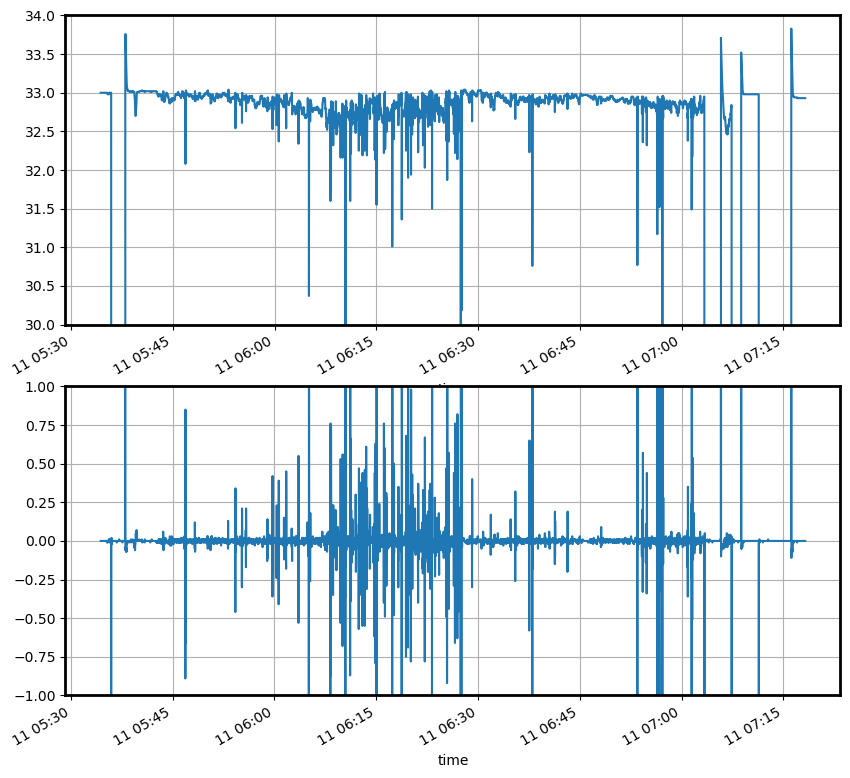

In [6]:
def plot_salinity(df, **kwargs):

    fig, axes = plt.subplots(2,1, figsize=(10,10))
    ax = axes[0]
    df.salinity.plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([30,34])

    ax = axes[1]
    df.salinity.diff().plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([-1,1])

plot_salinity(df)

fractions of salinity difference (with smoothed salinity) lower than 0.2 psu = 96.7%


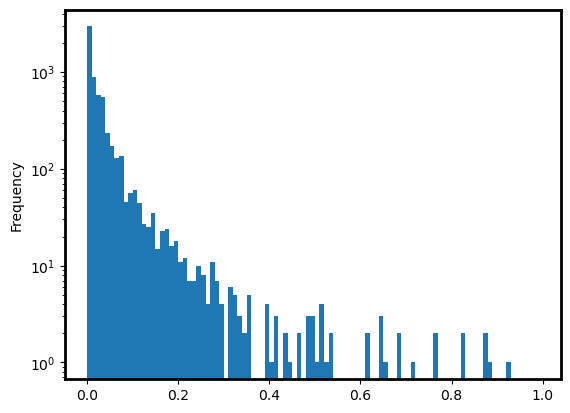

In [7]:
# salinity smoothing
rule = "10s" # 20s at 2m/s is 40m
dsalinity_threshold = 0.2

fig, ax = plt.subplots(1,1)
dfs = df.rolling(window=rule).median()
ds = df.salinity-dfs.salinity
np.abs(ds).plot.hist(bins=np.arange(0,1,.01), ax=ax)
ax.set_yscale("log")

_frac = (ds.loc[np.abs(ds)<dsalinity_threshold].index.size / ds.index.size)
print(f"fractions of salinity difference (with smoothed salinity) lower than {dsalinity_threshold} psu = {_frac*100:.1f}%")

### plot one cast time series

Search to highlight casts quality

In [8]:
if p=="hydrophone":

    _df = df.loc["2022-05-17 08:50:00":"2022-05-17 08:55:00"]
    d = cp["hydrophone"]["ctd"]["c6"]

    _df = _df.loc[:,["depth", "temperature", "salinity", "DO_mgL"]]
    _df["salinity"] = _df["salinity"].where(_df["salinity"]>30)

    axes = _df.plot(subplots=True, figsize=(10,10), grid=True, layout=(2,2))
    for ax in axes.flatten():
        ax.grid(which='minor', axis='both', linestyle='--')
        ax.axvline(d.start.time, color="k")
        ax.axvline(d.end.time, color="k")

# trim, filter and store

In [9]:
# transect parameters
ds = 20. # m, spacing
vmin=0.5 # m/s, tune search parameter

s_vars = ["salinity", "conductivity", "SA"]

D = {}
for label, d in cp[p][s].items():
    if (isinstance(labels, str) and labels=="all") or d.label in labels:
        # trim first to exclude irrelevant values
        _df = df.ts.trim(d)
        if d.label[0]=="u":
            # underway data
            print(d, "underway processing")
            ## simple temporal average
            #_df = _df.sw.resample("20s", op="median")
            ## despike salinity
            if despike:
                #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
                _dfs = _df.rolling(window=rule).median() 
                _ds = _df.salinity - _dfs.salinity
                _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
                # interpolate gaps
                _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
            ## interpolate on a regularly sampled transect
            _df = _df.geo.compute_transect(ds, vmin=vmin)
            # update temperature, salinity and sigma0 from PA, CT
            _df.sw.update_eos()
        elif d.label[0]=="c":
            print(d, "cast processing")
            _df = _df.sw.compute_vertical_profile(1.)
            _df.sw.update_eos()
        D[d.label] = _df
    else:
        print(f"skipping {d.label}")

u0 / start 2022-05-11 05:39:00 -0.22 49.36 / end 2022-05-11 07:03:00 -0.24 49.33 underway processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
u1 / start 2022-05-11 07:06:00 -0.23 49.33 / end 2022-05-11 07:07:00 -0.23 49.33 underway processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
u2 / start 2022-05-11 07:09:20 -0.22 49.32 / end 2022-05-11 07:11:10 -0.22 49.32 underway processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
u3 / start 2022-05-11 07:16:38 -0.26 49.32 / end 2022-05-11 07:18:00 -0.26 49.32 underway processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
skipping u4
skipping c5
skipping c6


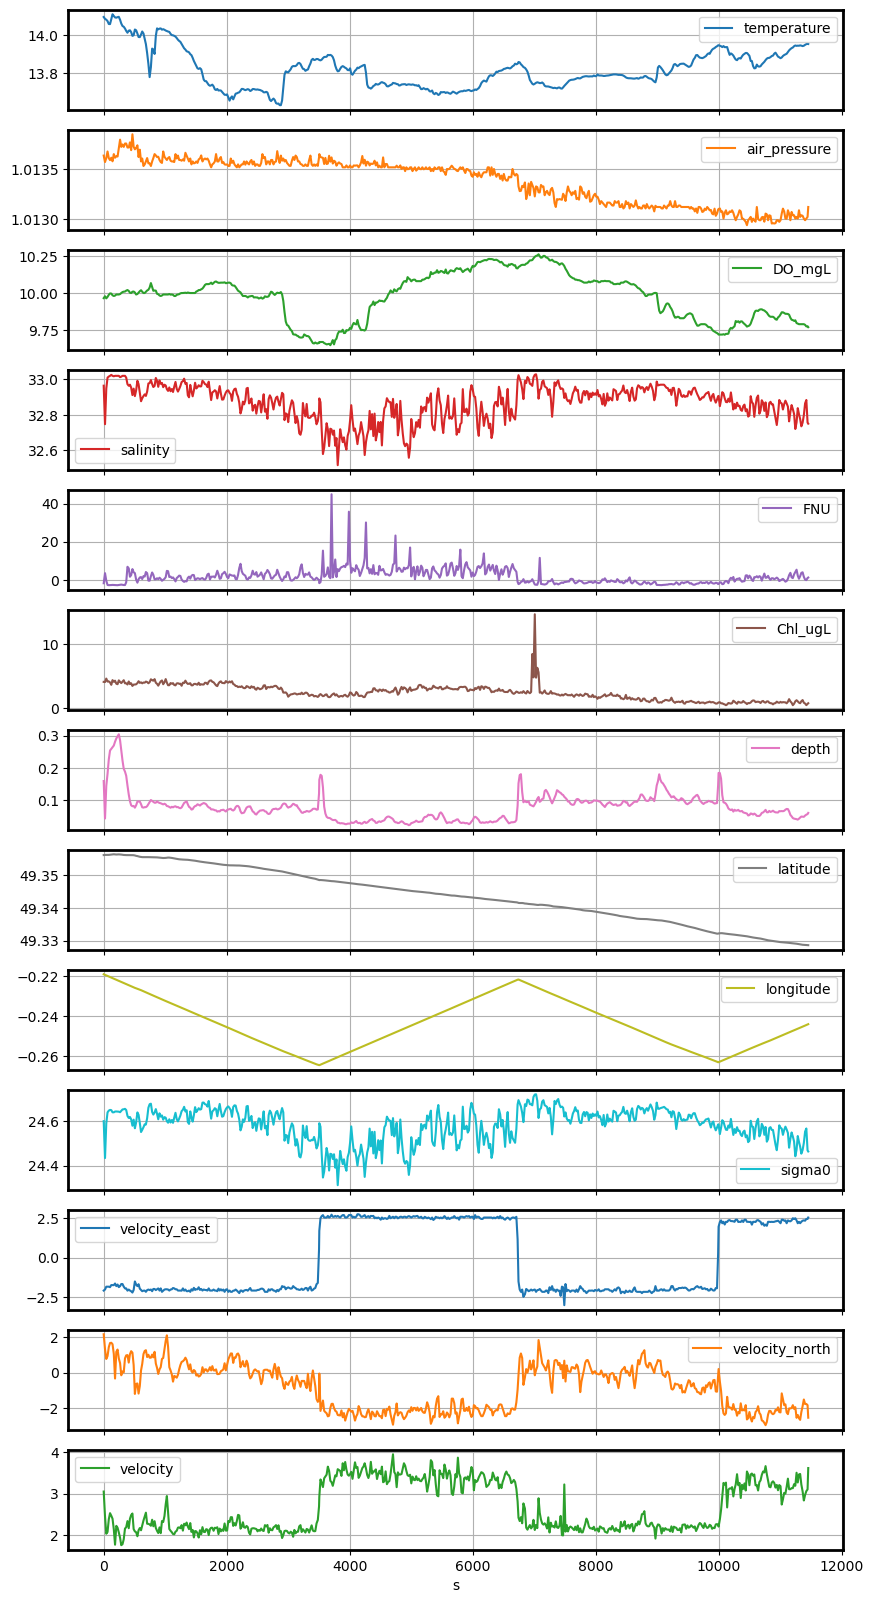

In [11]:
#_df = D["u0"] # drifters0 day0
#_df = D["u4"] # drifters0 day1
#_df = D["c0"] # drifters1 day0
#_df = D["c19"] # drifters1 day1
_df = D["u0"] # drifters1 day1

col_drop = ["time", "SA", "CT", "conductivity", "x", "y", "ux", "uy", "pressure", "DO_p", "Chl_RFU"]

_df.drop(columns=col_drop, errors="ignore").plot(subplots=True, figsize=(10,20), grid=True);

### store

In [40]:
for d, _df in D.items():
    _df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], f'{p}_{s}_{d}.nc'), mode="w")

---

## old stuff

In [ ]:
file = "sonde_benji_13.csv"
file_path = os.path.join(root_dir, file)
df = read_sonde_lern(file_path, stype=1)

['Date', 'Time', 'Site', 'Unit ID', 'User ID', 'ï¿½C-21A101173', 'mmHg-20L100404', 'DO %-21A100555', 'DO mg/L-21A100555', 'C-mS/cm-21A101173', 'SAL-PSU-21A101173', 'DEP m-20H100561']


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

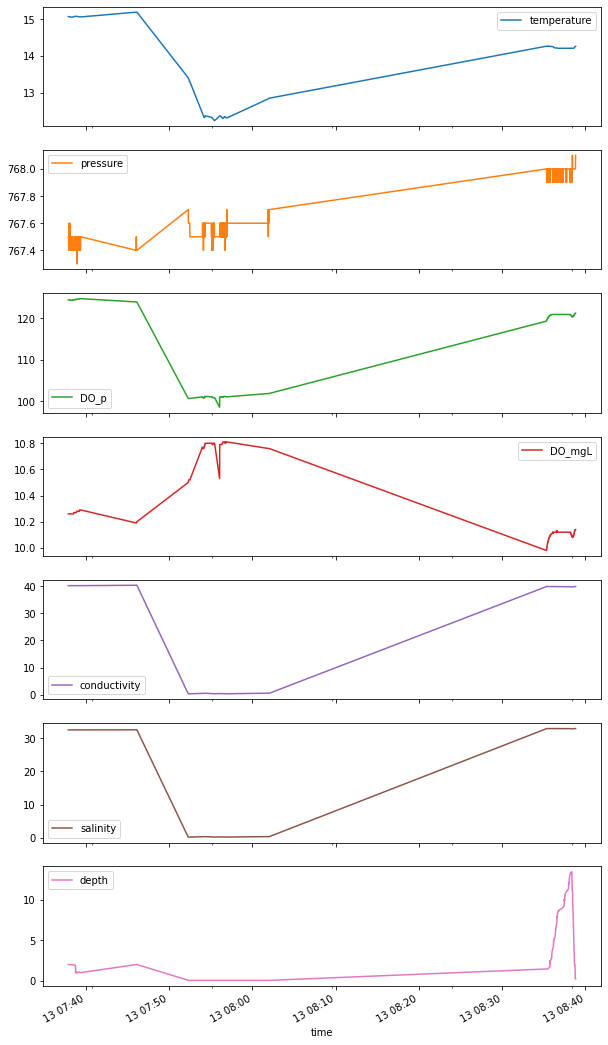

In [ ]:
df.plot(subplots=True, figsize=(10,20))